From the code for the following article [Sub-sampling for Efficient Non-Parametric Bandit Exploration](https://arxiv.org/abs/2010.14323)

In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
from MAB import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Parameters and aliases for all algorithms

In [3]:
# Enter the parameters of each algorithms
param = {'SSMC': {}, 'WR_SDA': {}, 'RB_SDA': {}, 'BESA': {},
         'TS': {}, 'kl_ucb': {'f': np.log}, 'PHE': {'a': 1.1}, 'vanilla_bootstrap': {}, 'LB_SDA': {},
         'LDS_SDA': {}, 'non_parametric_TS': {}, 'IMED': {}, 'Bootstrapped_TS': {'M': 10, 'prior': np.random.random},
         'ReBoot': {'sigma': 1}, 'ReBootG': {'sigma': 2.}}

mapping = {'B': BetaBernoulliMAB, 'G': GaussianMAB, 'Exp': ExponentialMAB, 'TG': TruncGaussianMAB}
mapping_name = {'B': 'Bernoulli', 'G': 'Gaussian', 'Exp': 'Exponential', 'TG': 'Truncated Gaussian'}

### Parallelized runs of multiple algorithms on the same bandit

In [4]:
bandit = 'B'  # 'B', 'G', 'Exp', 'TG'
p = [0.7, 0.5]  # parameters for the arms distribution
T = 1000  # Horizon
N = 100  # Number of MC runs
step = 25  # If results are saved trajectories are stored for all rounds such that t%step=0
algs = ['TS', 'RB_SDA', 'kl_ucb']  # Select some Algorithms (check param file for availability)

res, traj = multiprocess_MC(
    (bandit, p, T, N, algs, param, step, 'mean'),
    plot=False, 
    caption=None,
)

Running on 4 cores
Execution time: 24.58769130706787 seconds


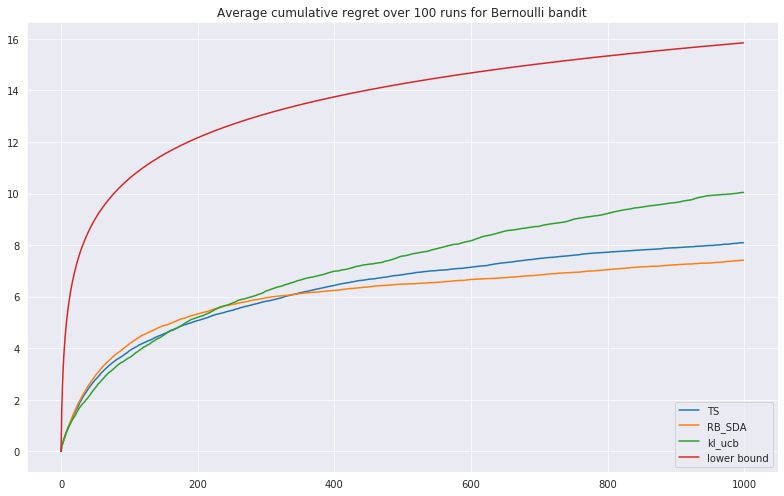

In [5]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()

### Manual runs of algorithms

In [6]:
gap = np.max(np.max(p) - np.array(p))
nb_arms = len(p)

# Optimal Explore-then-commit visits per arm
m_star = int(np.floor(4 / gap ** 2 * np.log(T * gap ** 2 / 4)) / nb_arms)

m_minus = int(np.floor(m_star * 0.4))  # 60% less exploration
m_plus = int(np.floor(m_star * 1.4))  # 40% more exploration

model = mapping[bandit](p)

all_r = []
for m in [m_star, m_minus, m_plus]:
    r, _ = model.MC_regret('ExploreCommit', N, T, {'m': m}, step)
    all_r.append(r)
all_r.append(model.Cp * np.log(1 + np.arange(T)))
res = pd.DataFrame(all_r).T
res.columns = ['optimal', 'less exploration', 'more exploration', 'lower bound']
res['lower bound'].iloc[0] = 0

Computing 100 simulations: 100%|██████████| 100/100 [00:00<00:00, 163.38it/s]


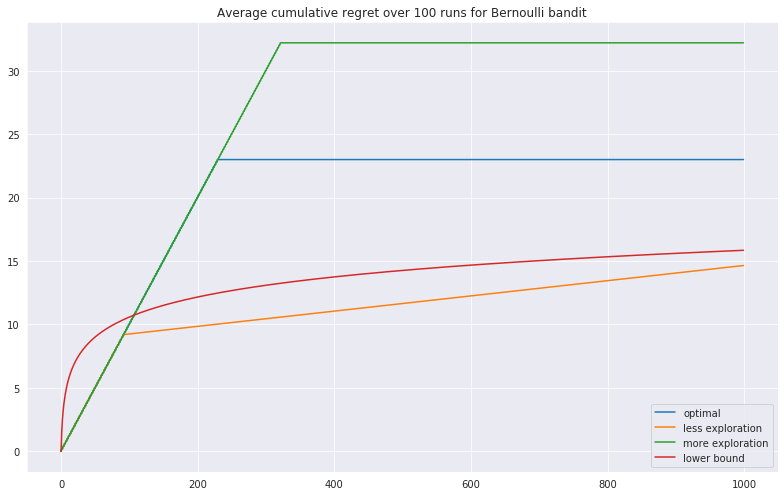

In [7]:
with sns.axes_style('darkgrid'):
    fig, ax = plt.subplots(figsize=(11, 7), nrows=1, ncols=1)

    res.plot(ax=ax)
    
    ax.legend(loc='lower right')
    ax.set_title('Average cumulative regret over {} runs for {:s} bandit'.format(N, mapping_name[bandit]))

    plt.tight_layout()
    plt.show()